In [1]:
from Model.transformer import save_model,SpatialTransformer,CustomDataset,load_model,relative_l2_loss
import torch
from torch.utils.data import Dataset, DataLoader

## load_model

In [ ]:
model = SpatialTransformer()

In [3]:
data = torch.load("/root/NC_Dataset/2d/dam2d/trimask.pth")[:, :, 0, :, :]
dataset = CustomDataset(data)
dataloader = DataLoader(dataset, batch_size=40, shuffle=True)

In [4]:
import numpy as np 
data_slice = np.where(data == 0, np.nan, data)  # Replace zeros with NaN

In [ ]:
model = load_model(model, load_path="/root/POFzhaoyang/Checkpoints/Triangle/tri_model_epoch_999.pth", device="cuda:0")

In [ ]:
import torch

# 假设你已经有一个加载好的模型变量名为model
# 你可以通过下面的代码统计模型的总参数量

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 计算参数量
total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")

In [ ]:
data.shape

In [8]:
output  = model(data[:,0:1,:,:])

In [ ]:
relative_l2_loss(output,data[:,1:31,:,:])

###计算累计

In [16]:
cir_model = load_model(model, load_path="/root/POFzhaoyang/Checkpoints/Circle/cir_model_epoch_999.pth", device="cuda:0")
cir_data= torch.load("/root/NC_Dataset/2d/dam2d/cirmask.pth")[:, :, 0, :, :]
cir_out = cir_model(cir_data[:,0:1,:,:])

Model loaded from /root/POFzhaoyang/Checkpoints/Circle/cir_model_epoch_999.pth, starting from epoch 999


In [22]:
square_model = load_model(model, load_path="/root/POFzhaoyang/Checkpoints/Squre/Squre_model_epoch_999.pth", device="cuda:0")
square_data= torch.load("/root/NC_Dataset/2d/dam2d/squmask.pth")[:, :, 0, :, :]
square_out = square_model(square_data[:,0:1,:,:])

Model loaded from /root/POFzhaoyang/Checkpoints/Squre/Squre_model_epoch_999.pth, starting from epoch 999


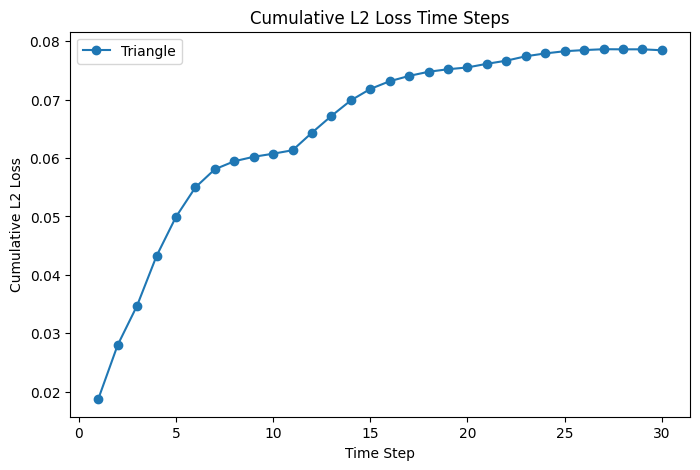

In [19]:
# 计算逐时间步的累计误差
import torch
import matplotlib.pyplot as plt
time_steps =30
# 初始化累积误差列表
cumulative_l2_tri = []
for t in range(time_steps):
    # 当前时间步的预测和真实值
    step_loss = relative_l2_loss(output[:, t, :, :], data[:, t + 1, :, :])
    if t == 0:
        cumulative_loss = step_loss
    else:
        cumulative_loss = (cumulative_loss * t + step_loss) / (t + 1)
    cumulative_l2_tri.append(cumulative_loss.item())

# 绘制折线图
plt.figure(figsize=(8, 5))
plt.plot(range(1, time_steps + 1), cumulative_l2_tri, marker='o', linestyle='-',label="Triangle")
plt.xlabel('Time Step')
plt.ylabel('Cumulative L2 Loss')
plt.title('Cumulative L2 Loss Time Steps')
plt.legend()

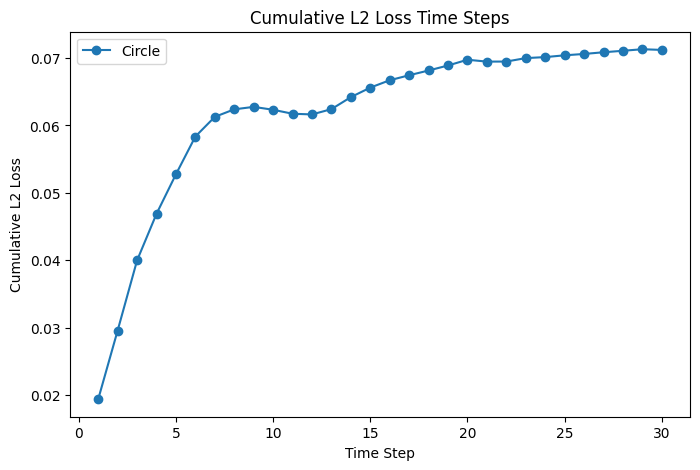

In [18]:
# 计算逐时间步的累计误差
import torch
import matplotlib.pyplot as plt
time_steps =30
# 初始化累积误差列表
cumulative_l2_cir = []
for t in range(time_steps):
    # 当前时间步的预测和真实值
    step_loss = relative_l2_loss(cir_out[:, t, :, :], cir_data[:, t + 1, :, :])
    if t == 0:
        cumulative_loss = step_loss
    else:
        cumulative_loss = (cumulative_loss * t + step_loss) / (t + 1)
    cumulative_l2_cir.append(cumulative_loss.item())

# 绘制折线图
plt.figure(figsize=(8, 5))
plt.plot(range(1, time_steps + 1), cumulative_l2_cir, marker='o', linestyle='-',label="Circle")
plt.xlabel('Time Step')
plt.ylabel('Cumulative L2 Loss')
plt.title('Cumulative L2 Loss Time Steps')
plt.legend()

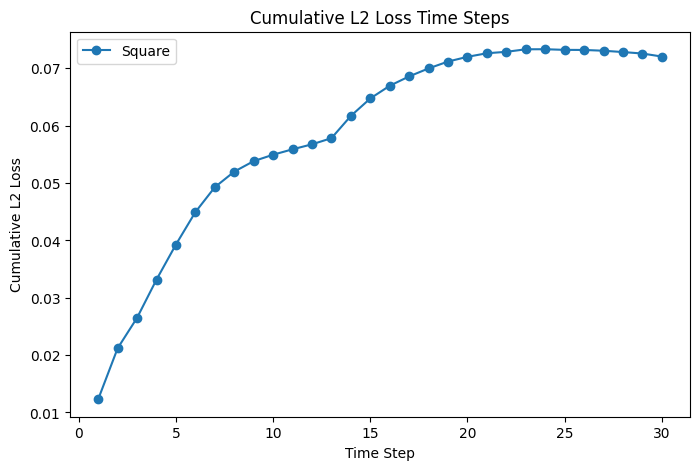

In [25]:
# 计算逐时间步的累计误差
import torch
import matplotlib.pyplot as plt
time_steps =30
# 初始化累积误差列表
cumulative_l2_squ = []
for t in range(time_steps):
    # 当前时间步的预测和真实值
    step_loss = relative_l2_loss(square_out[:, t, :, :], square_data[:, t + 1, :, :])
    if t == 0:
        cumulative_loss = step_loss
    else:
        cumulative_loss = (cumulative_loss * t + step_loss) / (t + 1)
    cumulative_l2_squ.append(cumulative_loss.item())

# 绘制折线图
plt.figure(figsize=(8, 5))
plt.plot(range(1, time_steps + 1), cumulative_l2_squ, marker='o', linestyle='-',label="Square")
plt.xlabel('Time Step')
plt.ylabel('Cumulative L2 Loss')
plt.title('Cumulative L2 Loss Time Steps')
plt.legend()

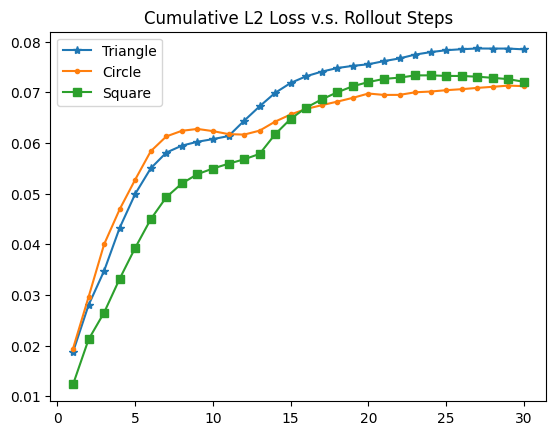

In [32]:
plt.plot(range(1, time_steps + 1), cumulative_l2_tri, marker='*', linestyle='-',label="Triangle")
plt.plot(range(1, time_steps + 1), cumulative_l2_cir, marker='.', linestyle='-',label="Circle")
plt.plot(range(1, time_steps + 1), cumulative_l2_squ, marker='s', linestyle='-',label="Square")
plt.title('Cumulative L2 Loss v.s. Rollout Steps')
plt.legend()
plt.savefig("CL.png",dpi=300, bbox_inches='tight')

In [88]:
output = output.detach().cpu().numpy()

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'data_slice' is your ground truth and 'output' is your prediction,
# and both are four-dimensional arrays with shape [num_cases, num_steps, height, width]
# Here we select the 15th case, 2nd channel (Python indexing starts at 0)

steps = [0, 5, 10, 20, 25, 29]  # Actual steps corresponding to the indices

fig, axes = plt.subplots(3, len(steps), figsize=(15, 12))  # Create a grid of 3 rows and len(steps) columns
fig.suptitle('Analysis of Steps', fontsize=16, y=0.97)
pred =  output+ data_slice[:,1:31,:,:]
difference = pred - data_slice[:,1:31,:,:]
for i, step in enumerate(steps):
    # Ground truth
    im0 = axes[0, i].imshow(data_slice[0, step+1, :, :], extent=(0, 0.61, 0, 1.6), origin='lower', cmap='jet',vmin=0,vmax=0.14)
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Step {step + 1}")

    # Prediction
    
    im1 = axes[1, i].imshow(pred[0, step, :, :], extent=(0, 0.61, 0, 1.6), origin='lower', cmap='jet',vmin=0,vmax=0.14)
    axes[1, i].axis('off')

    # Difference
    im2 = axes[2, i].imshow(difference[0, step, :, :], extent=(0, 0.61, 0, 1.6), origin='lower', cmap='jet',vmin=0,vmax=0.02)
    axes[2, i].axis('off')

# Adjust subplot spacing
plt.subplots_adjust(wspace=0.01, hspace=0.1)
plt.tight_layout(pad=2)

# Add a color bar to each row
cbar0 = fig.colorbar(im0, ax=axes[0, :].ravel().tolist(), orientation='vertical', pad=0.02, aspect=30, shrink=0.9)
cbar0.set_label(' Depth')
cbar1 = fig.colorbar(im1, ax=axes[1, :].ravel().tolist(), orientation='vertical', pad=0.02, aspect=30, shrink=0.9)
cbar1.set_label('Depth')
cbar2 = fig.colorbar(im2, ax=axes[2, :].ravel().tolist(), orientation='vertical', pad=0.02, aspect=30, shrink=0.9)
cbar2.set_label('Difference')

# Save the image with tight layout adjustments
plt.savefig("Compare_cir.png", dpi=300, bbox_inches='tight')


In [74]:
transformer_encoder = model.transformer_encoder